# Initialisation and Dependencies

In [1]:
## TRAINED ON KAGGLE TPUs

# DEPENDENCIES:
import os, random, re, math, time
random.seed(a=42)

from glob import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets
import PIL

In [2]:
#=================================== INITIALIZE THE DEVICE ========================================
DEVICE = "TPU" #or GPU

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


# Variables For Making Dataset

1. tfrec_shape = image shape to choose dataset 256, 384, 512, 768
2. comp_data = "2020"(only 2020 competition data) or "2019-2020"(2017-2020 data)
3. hair_augm = bool (whether hair augment is applied)
4. Coarse Dropout Variables:
   * DROP_FREQ  Determines proportion of train images to apply coarse dropout to/ (0,1)
   * DROP_CT    How many squares to remove from train images when applying dropout
   * DROP_SIZE  The size of square side equals IMG_SIZE * DROP_SIZE / (0,1)
5. Transform Augmentation Variables:
   * rot,     rotation
   * shr,     shear zoom
   * hzoom,   height zoom
   * wzoom,   width shift
   * hshift,  height shift
   * wshift,  width shift
6. crop_size random crop size for each original image size

In [3]:
tfrec_shape = 512 # 256, 384, 512, 768
comp_data = "2019-2020" # "2019-2020" or "2020"
crop_size = {256: 250, 384: 370, 512: 500, 768: 750}

# net size for each original image size:
if comp_data == "2020":
    net_size = {256: 248, 384: 370, 512: 500, 768: 750}
elif comp_data == "2019-2020":
    net_size = {256: 250, 384: 370, 512: 500, 768: 750}

# edit this to change augmentation:
CFG = dict(
            batch_size = 16,
            read_size = tfrec_shape,
            crop_size = crop_size[tfrec_shape],
            net_size = net_size[tfrec_shape],
            # DATA AUGMENTATION:
            rot = 180.0,
            shr = 1.5,
            hzoom = 6.0,
            wzoom = 6.0,
            hshift = 6.0,
            wshift = 6.0,
            # COARSE DROPOUT:
            DROP_FREQ = 0.85, 
            DROP_CT = 20,
            DROP_SIZE = 0.07,
            # HAIR AUGMENTATION:
            hair_augm = True)

# Importing Datasets

In [4]:
BASEPATH = "../input/siim-isic-melanoma-classification"
df_train = pd.read_csv(os.path.join(BASEPATH, 'train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))

# 2020 TFRecords
GCS_PATH = KaggleDatasets().get_gcs_path(f'melanoma-{tfrec_shape}x{tfrec_shape}')

# 2019 TFRecords
GCS_PATH_2019 = KaggleDatasets().get_gcs_path(f'isic2019-{tfrec_shape}x{tfrec_shape}')

# TRAIN DATASET
if comp_data == "2020":
    files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
elif comp_data == "2019-2020":
    files_train = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
    files_train += tf.io.gfile.glob(GCS_PATH_2019 + '/train*.tfrec')
    files_train = np.sort(np.array(files_train))
    
# TEST DATASET
files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

# MELANOMA-HAIR IMAGES
GCS_PATH_hair_images = KaggleDatasets().get_gcs_path('melanoma-hairs')
hair_images = tf.io.gfile.glob(GCS_PATH_hair_images + '/*.png')
# loading images as tensors
hair_images_tf=tf.convert_to_tensor(hair_images)

# the maximum number of hairs to augment:
n_max= 20
if tfrec_shape != 256:
    scale=tf.cast(CFG['crop_size']/256, dtype=tf.int32)

# Pre-processing and Augmentation Functions

In [5]:
#==================== FUNCTION TO PERFORM HAIR REMOVAL ON IMAGE ====================================

def hair_aug_tf(input_img, augment=True):
    
    if augment:
    
        # Copy the input image, so it won't be changed
        img = tf.identity(input_img)

        # Unnormalize: Returning the image from 0-1 to 0-255:
        img = tf.multiply(img, 255)

        # Randomly choose the number of hairs to augment (up to n_max)
        n_hairs = tf.random.uniform(shape=[], maxval=tf.constant(n_max)+1,dtype=tf.int32)

        im_height = tf.shape(img)[0]
        im_width = tf.shape(img)[1]

        if n_hairs == 0:
            # Normalize the image to [0,1]
            img = tf.multiply(img, 1/255)
            return img

        for _ in tf.range(n_hairs):

            # Read a random hair image
            i = tf.random.uniform(shape=[], maxval=tf.shape(hair_images_tf)[0],dtype=tf.int32)
            fname = hair_images_tf[i]
            bits = tf.io.read_file(fname)
            hair = tf.image.decode_jpeg(bits)

            # Rescale the hair image to the right size
            if tfrec_shape != 256:
                # new_height, new_width, _  = scale*tf.shape(hair)
                new_width = scale*tf.shape(hair)[1]
                new_height = scale*tf.shape(hair)[0]
                hair = tf.image.resize(hair, [new_height, new_width])

            # Random flips of the hair image
            hair = tf.image.random_flip_left_right(hair)
            hair = tf.image.random_flip_up_down(hair)

            # Random number of 90 degree rotations
            n_rot = tf.random.uniform(shape=[], maxval=4,dtype=tf.int32)
            hair = tf.image.rot90(hair, k=n_rot)

            # The hair image height and width (ignore the number of color channels)
            h_height = tf.shape(hair)[0]
            h_width = tf.shape(hair)[1]

            # The top left coord's of the region of interest (roi) where the augmentation will be performed
            roi_h0 = tf.random.uniform(shape=[], maxval=im_height - h_height + 1, dtype=tf.int32)
            roi_w0 = tf.random.uniform(shape=[], maxval=im_width - h_width + 1, dtype=tf.int32)

            # The region of interest
            roi = img[roi_h0:(roi_h0 + h_height), roi_w0:(roi_w0 + h_width)]  

            # Convert the hair image to grayscale (slice to remove the trainsparency channel)
            hair2gray = tf.image.rgb_to_grayscale(hair[:, :, :3])

            # Threshold:
            mask = hair2gray>10

            img_bg = tf.multiply(roi, tf.cast(tf.image.grayscale_to_rgb(~mask), dtype=tf.float32))
            hair_fg = tf.multiply(tf.cast(hair[:, :, :3], dtype=tf.int32), tf.cast(tf.image.grayscale_to_rgb(mask), dtype=tf.int32))

            dst = tf.add(img_bg, tf.cast(hair_fg, dtype=tf.float32))

            paddings = tf.stack([[roi_h0, im_height-(roi_h0 + h_height)], [roi_w0, im_width-(roi_w0 + h_width)],[0, 0]])
            # Pad dst with zeros to make it the same shape as image.
            dst_padded=tf.pad(dst, paddings, "CONSTANT")

            # Create a boolean mask with zeros at the pixels of the augmentation segment and ones everywhere else
            mask_img=tf.pad(tf.ones_like(dst), paddings, "CONSTANT")
            mask_img=~tf.cast(mask_img, dtype=tf.bool)

            # Make a hole in the original image at the location of the augmentation segment
            img_hole=tf.multiply(img, tf.cast(mask_img, dtype=tf.float32))

            # Inserting the augmentation segment in place of the hole
            img = tf.add(img_hole, dst_padded)

        # Normalize the image to [0,1]
        img = tf.multiply(img, 1/255)
        
        return img
    else:
        return input_img

In [6]:
#===================== FUNCTION TO PERFORM COARSE AUMENTATION ON IMAGE =============================

def dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # input image [dim,dim,3] 
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE 
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [7]:
#============================ ROTATION, SHEAR, ZOOM, TRANSFORMS ====================================

# FUNCTION TO GET ROTATED MATRIX:

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

# FUNCTION TO APPLY AUGMENTATION TRANSFORMS:

def transform(image, cfg):    
    # input image - [dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg["read_size"]
    XDIM = DIM%2
    
    rot = cfg['rot'] * tf.random.normal([1], dtype='float32')
    shr = cfg['shr'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['hzoom']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['wzoom']
    h_shift = cfg['hshift'] * tf.random.normal([1], dtype='float32') 
    w_shift = cfg['wshift'] * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift)

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [8]:
#========================== FUNCTION TO READ TFRECORD FILEPATHS ====================================

def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

In [9]:
#====================== FUNCTION TO APPLY AUGMENTATION TO EACH IMAGE ===============================

def prepare_image(img, cfg=None, augment=True):
    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['read_size'], cfg['read_size']])
    img = tf.cast(img, tf.float32) / 255.0 # # Cast and normalize the image to [0,1]
    
    if augment:
        
        # Data augmentation
        img = transform(img, cfg)
        img = tf.image.random_crop(img, [cfg['crop_size'], cfg['crop_size'], 3])
        
        # Coarse dropout
        img = dropout(img, 
                      DIM=cfg['crop_size'], 
                      PROBABILITY=cfg['DROP_FREQ'], 
                      CT=cfg['DROP_CT'], 
                      SZ=cfg['DROP_SIZE'])
        
        # Other augmentations
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
        
        # Hair augmentation
        img = hair_aug_tf(img, augment=cfg['hair_augm'])
    else:
        img = tf.image.central_crop(img, cfg['crop_size'] / cfg['read_size'])
                                   
    img = tf.image.resize(img, [cfg['net_size'], cfg['net_size']])
    img = tf.reshape(img, [cfg['net_size'], cfg['net_size'], 3])        
    return img

In [10]:
#==================== FUNCTIONS TO OBTAIN IMAGES FROM TFRECORD FILEPATHS ============================

# COUNT NUMBER OF IMAGES IN FILEPATH:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# OBTAIN DATASET:
def get_dataset(files, 
                cfg, 
                augment = False, 
                shuffle = False, 
                repeat = False, 
                labeled=True, 
                return_image_names=True):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, cfg=cfg),imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(cfg['batch_size'] * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

# Obtaining Data and Displaying

In [11]:
#===========================  FUNCTION TO DISPLAY IMAGES AS MOSAIC =================================
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', 
                           size=(thumb_size*cols + (cols-1), thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)

# IMAGES IN DATASET:
num_training_images = int(count_data_items(files_train))
num_test_images = count_data_items(files_test)
print('Dataset: {} training images, {} unlabeled test images'.format(
    num_training_images, num_test_images))

Dataset: 57964 training images, 10982 unlabeled test images


## Original Training Images

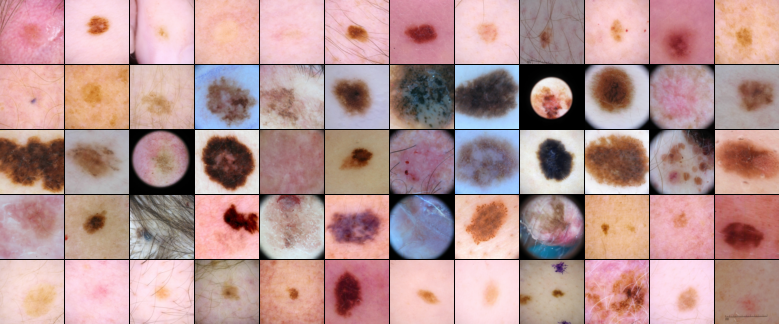

In [12]:
# Train Data
ds = get_dataset(files_train, CFG).unbatch().take(12*5) # augment = False
show_dataset(64, 12, 5, ds)

## Augmented Training Images

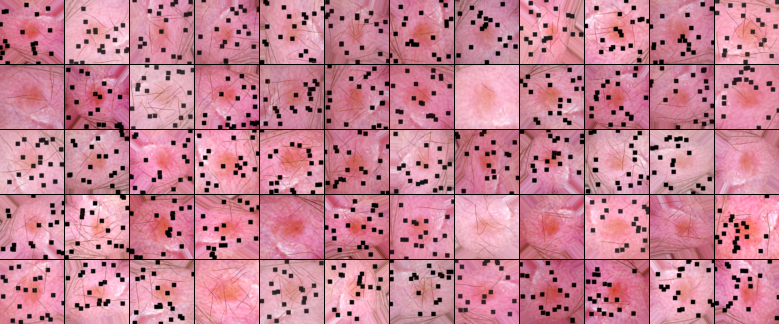

In [13]:
# Image Augmentation
ds = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
ds = ds.take(1).cache().repeat()
ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda img, target: (prepare_image(img, cfg=CFG, augment=True), target), num_parallel_calls=AUTO)
ds = ds.take(12*5)
ds = ds.prefetch(AUTO)
show_dataset(64, 12, 5, ds)

## Test Images

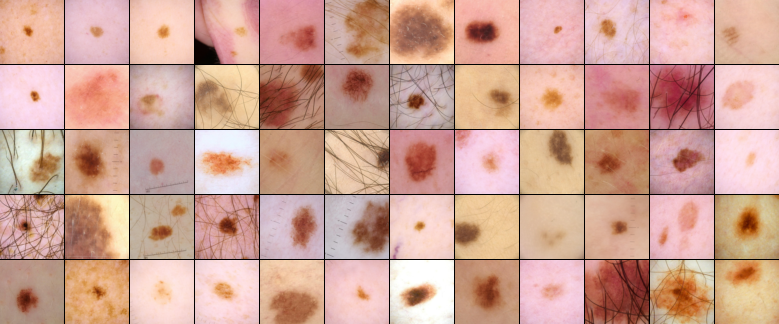

In [14]:
# Test Data
ds = get_dataset(files_test, CFG, labeled=False).unbatch().take(12*5)
show_dataset(64, 12, 5, ds)

In [15]:
ds_train = get_dataset(files_train, CFG, augment=True, shuffle=True, repeat=True)
ds_train = ds_train.map(lambda img, label: (img, tuple([label])))
#steps_train = count_data_items(files_train) / (CFG['batch_size'] * REPLICAS)
ds_test = get_dataset(files_test, CFG, labeled=False)